In [15]:
from torchvision import utils
from dataloader import *
# from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch
import time

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [17]:
class FCN(torch.nn.Module):

    def __init__(self, n_class):
        super(FCN, self).__init__()
        self.n_class = n_class
        self.conv1   = nn.Conv2d(3, 32, kernel_size=(3,5), stride=(2,4), padding=1, dilation=1)
        self.bnd1    = nn.BatchNorm2d(32)
        self.conv2   = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bnd2    = nn.BatchNorm2d(64)
        self.conv3   = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bnd3    = nn.BatchNorm2d(128)
        self.conv4   = nn.Conv2d(128,256, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bnd4    = nn.BatchNorm2d(256)
        self.conv5   = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bnd5    = nn.BatchNorm2d(512)
        self.relu    = nn.ReLU(inplace=True)
        
        self.deconv1 = nn.ConvTranspose2d(n_class, 512, kernel_size=2, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.decode  = nn.ConvTranspose2d(32, n_class, kernel_size=(3, 5), stride=(2,4), padding=1, dilation=1, output_padding=1)
        self.decod_bn= nn.BatchNorm2d(n_class)
        self.classifier = nn.Conv2d(512,n_class, kernel_size=1, stride=1, padding=0, dilation=1)
        self.class_bn = nn.BatchNorm2d(n_class)
        
    def forward(self, x):
        pool = nn.MaxPool2d(2, stride=2,return_indices = True)

        unpool = nn.MaxUnpool2d(2, stride=2)
        
        cx1 = self.relu(self.conv1(x))
        x1, indice1 = pool(cx1)
        x1 = self.bnd1(x1)
        print(x1.size())
        cx2 = self.relu(self.conv2(x1))
        x2, indice2 = pool(cx2)
        x2 = self.bnd2(x2)
        print(x2.size())
        cx3 = self.relu(self.conv3(x2))
        x3, indice3 = pool(cx3)
        print("x3, indice3" ,x3.size(), indice3.size())
        x3 = self.bnd3(x3)
        
        cx4 = self.relu(self.conv4(x3))
        x4, indice4 = pool(cx4)
        print("x4, indice4" ,x4.size(), indice4.size())
        x4 = self.bnd4(x4)
        
        cx5 = self.relu(self.conv5(x4))
        x5, indice5 = pool(cx5)
        print("x5, indice5" ,x5.size(), indice5.size())
        x5 = self.bnd5(x5)
        print("--- Done with Convolutions ---")
#         score = (self.relu(self.classifier(out_encoder))) 
        # Complete the forward function for the rest of the encoder
        print(x5.size())
        score = self.relu(self.classifier(x5))
        score = self.class_bn(score)
        print(score.size(), indice5.size(), cx5.size())
        z1 = self.bn1(self.deconv1(self.relu(score)))
        print(z1.size(), indice5.size(), cx5.size())
        z1 = unpool(z1, indice5)
        
        print(z1.size(),indice4.size())
        z2 = self.bn2(self.deconv2(self.relu(z1)))
        z2 = unpool(z2, indice4)
        
#         z2 = self.bn2(self.relu(self.deconv2(z1)))
        print(z2.size())
        z3 = self.bn3(self.deconv3(self.relu(z2)))
        z3 = unpool(z3, indice3)
        
#         z3 = self.bn3(self.relu(self.deconv3(z2)))
        print(z3.size())
        z4 = self.bn4(self.deconv4(self.relu(z3)))
        z4 = unpool(z4, indice2)
        
#         z4 = self.bn4(self.relu(self.deconv4(z3)))
        print(z4.size())
        z5 = self.bn5(self.deconv5(self.relu(z4)))
        z5 = unpool(z5, indice1)
        
        out_decoder = self.decode(self.relu(z5))
        out_decoder = self.decod_bn(out_decoder)
        print("out_decoder", out_decoder.size())
            
        # Complete the forward function for the rest of the decoder
        
#         score = self.classifier(out_decoder)                   

        return score  # size=(N, n_class, x.H/1, x.W/1)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

cuda:0
True


In [19]:
train_dataset = CityScapesDataset(csv_file='train.csv')
val_dataset = CityScapesDataset(csv_file='val.csv')
test_dataset = CityScapesDataset(csv_file='test.csv')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          num_workers=0,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=10,
                          num_workers=1,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=10,
                          num_workers=1,
                          shuffle=True)



In [20]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        print(m)
        torch.nn.init.xavier_uniform_(m.weight.data)
#         torch.nn.init.xavier_uniform(m.bias.data)
        m.bias.data.zero_()
epochs     = 100
criterion = torch.nn.MSELoss()
fcn_model = FCN(n_class=34)
fcn_model.apply(init_weights)
#fcn_model = torch.load('best_model')
optimizer = optim.Adam(fcn_model.parameters(), lr=5e-3)

Conv2d(3, 32, kernel_size=(3, 5), stride=(2, 4), padding=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
ConvTranspose2d(34, 512, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
ConvTranspose2d(32, 3, kernel_size=(3, 5), stride=(2, 4), padding=(1, 1), output_padding=(1, 1))
Conv2d(512, 34, kernel_size=(1, 1), stride=(1, 1))


torch.Size([10, 34, 1024, 2048])
torch.Size([10, 1024, 2048])
torch.Size([10, 3, 1024, 2048])
torch.Size([10, 3, 1024, 2048])
torch.Size([10, 32, 256, 256])
torch.Size([10, 64, 64, 64])
x3, indice3 torch.Size([10, 128, 16, 16]) torch.Size([10, 128, 16, 16])
x4, indice4 torch.Size([10, 256, 4, 4]) torch.Size([10, 256, 4, 4])
x5, indice5 torch.Size([10, 512, 1, 1]) torch.Size([10, 512, 1, 1])
--- Done with Convolutions ---
torch.Size([10, 512, 1, 1])
torch.Size([10, 34, 1, 1]) torch.Size([10, 512, 1, 1]) torch.Size([10, 512, 2, 2])
torch.Size([10, 512, 1, 1]) torch.Size([10, 512, 1, 1]) torch.Size([10, 512, 2, 2])
torch.Size([10, 512, 2, 2]) torch.Size([10, 256, 4, 4])
torch.Size([10, 256, 8, 8])
torch.Size([10, 128, 32, 32])
torch.Size([10, 64, 128, 128])
out_decoder torch.Size([10, 3, 1024, 2048])
<class 'torch.Tensor'>


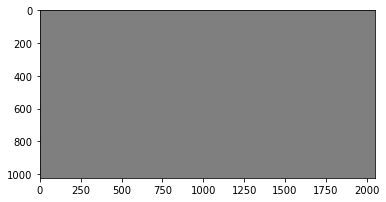

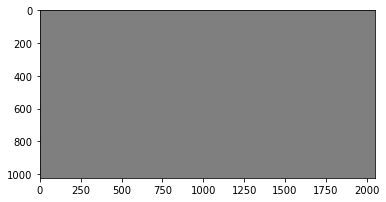

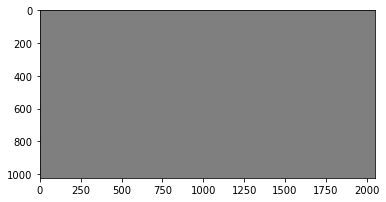

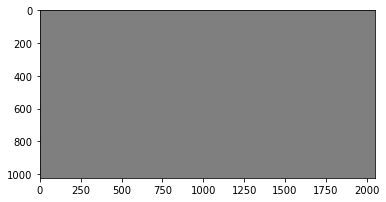

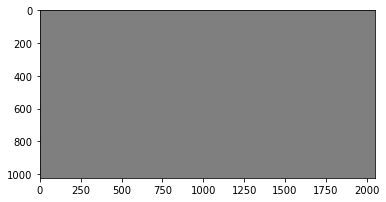

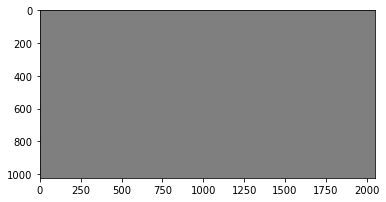

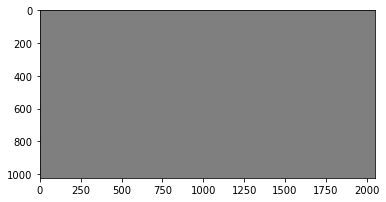

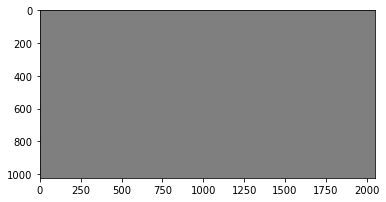

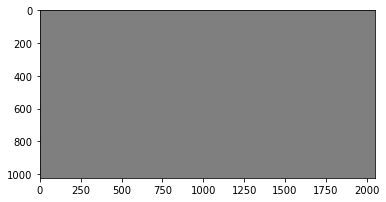

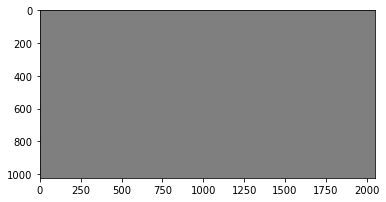

Finish epoch 0, time elapsed 14.451017141342163


In [21]:
use_gpu = torch.cuda.is_available()
use_gpu = False
if use_gpu:
    fcn_model = fcn_model.to(device)
    
def train():
    for epoch in range(epochs):
        ts = time.time()
        for iter, (X, tar, Y) in enumerate(train_loader):
            optimizer.zero_grad()

            print(tar.size())
            print(Y.size())
            print(X.size())

            if use_gpu:
                print("GPU")
                inputs = X.to(device)
                labels = Y.to(device)
            else:
                inputs, labels = X, Y
            print(inputs.size())
            outputs = fcn_model(inputs)
            break
            print(outputs.size())
            loss = criterion(outputs, labels)
            print(loss)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))
            
            break
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
#         torch.save(fcn_model, 'best_model')
        break

        val(epoch)
        fcn_model.train()


def val(epoch):
    fcn_model.eval()
    #Complete this function - Calculate loss, accuracy and IoU for every epoch
    # Make sure to include a softmax after the output from your model
    
def test():
    print(' ')
    #Complete this function - Calculate accuracy and IoU 
    # Make sure to include a softmax after the output from your model
    
if __name__ == "__main__":
    val(0)  # show the accuracy before training
    train()